<a href="https://colab.research.google.com/github/BibaswanBiswas/ChronosTrade-Stock-Market-Analysis-using-ML/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#LSTM MODEL FOR STOCK PRICE PREDICTION

In [ ]:
!pip install -q yfinance
#installing yfinance for dataset

In [ ]:
#common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
import itertools
import math
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
#ARIMA imports
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
#LSTM imports
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2020-12-29,221.996674,223.300003,218.333328,220.333328,68732400
2020-12-30,231.593338,232.199997,222.786667,224.000000,128538000
2020-12-31,235.223328,239.573334,230.373337,233.330002,148949700
2021-01-04,243.256668,248.163330,239.063339,239.820007,145914600
2021-01-05,245.036667,246.946671,239.733337,241.220001,96735600
...,...,...,...,...,...
2025-12-22,488.730011,498.829987,485.329987,489.880005,86916100
2025-12-23,485.559998,491.970001,482.839996,489.399994,58223600


<Axes: xlabel='Date'>

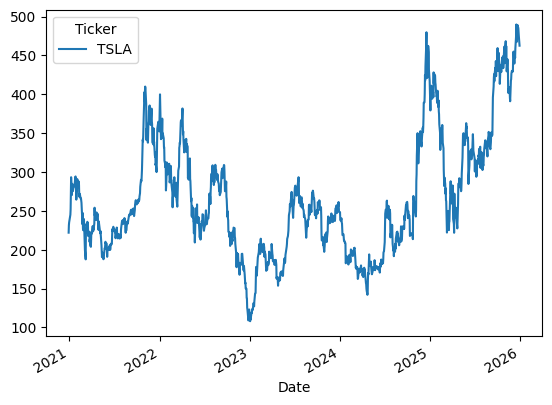

In [ ]:
df = yf.download(
    "TSLA",
    period = "5y",
    interval = "1d",
    progress = False
)


display(df)

df.Close.plot()
#Loading the dataset

In [ ]:
ts=df.Close#the dataset to be used
ts = ts.dropna()
# Check missing values
ts.isnull().sum()


,0
Ticker,
TSLA,0


In [ ]:
ts.index = pd.to_datetime(ts.index)
ts = ts.sort_index()
ts        #changing to datetime format

Ticker,TSLA
Date,
2020-12-29,221.996674
2020-12-30,231.593338
2020-12-31,235.223328
2021-01-04,243.256668
2021-01-05,245.036667
...,...
2025-12-22,488.730011
2025-12-23,485.559998
2025-12-24,485.399994


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(ts)

scaled_df = pd.DataFrame(
    scaled_data,
    index=ts.index,
    columns=ts.columns
)        #normalising the data set

In [ ]:
f=0.80#fraction to be used as training data
train_size=int(len(ts)*f)
train_data,test_data=scaled_df[:train_size],scaled_df[train_size:]

In [ ]:
'''ARIMA MODEL'''
train=train_data
test=test_data
ts_adf=scaled_df.copy()
result = adfuller(scaled_df)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

if result[1] > 0.05:                                              #p_value  >0.05 means we need to use differncing
    print("Series is non stationary; differencing is needed.")
else:
    print("Series is stationary; no differencing needed.")

ADF Statistic: -1.714643
p-value: 0.423584
Series is non stationary; differencing is needed.


ADF Statistic: -36.521110
p-value: 0.000000
1


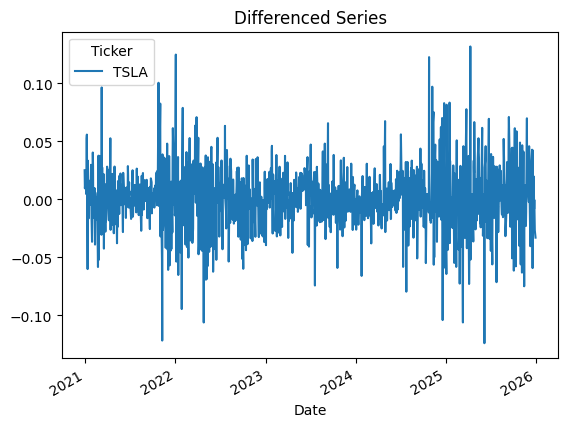

In [ ]:
#we apply differencing until p-value is <=0.05
d=0
while result[1]>0.05:
    ts_adf=ts_adf.diff()
    ts_adf = ts_adf.dropna()
    result = adfuller(ts_adf)
    d+=1
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
ts_adf.plot(title='Differenced Series')
print(d)
plt.show()

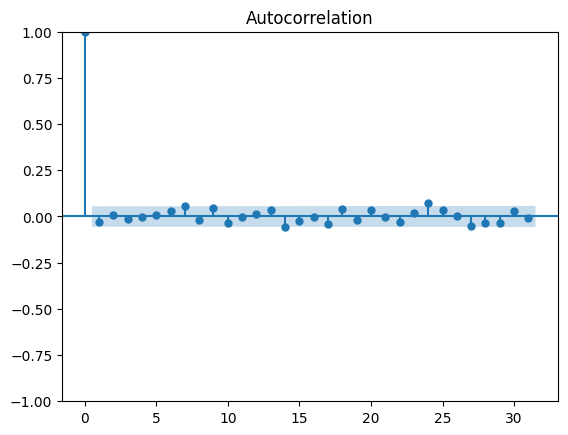

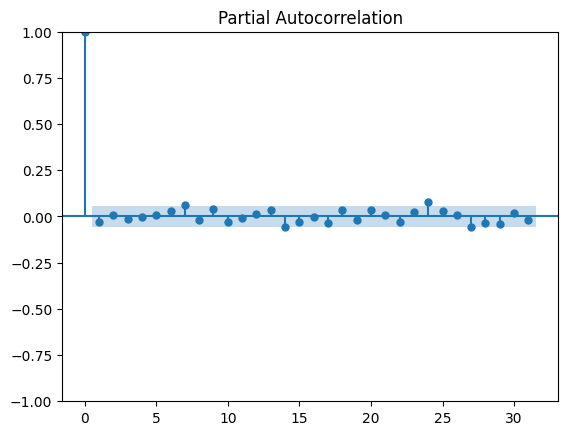

In [ ]:
#now,we plot the correlation coefficients
plot_acf(ts_adf)
plt.show()
plot_pacf(ts_adf)
plt.show()

In [ ]:
#Now, we do ARIMA model selection
p = range(0, 5)
q = range(0, 5)
pdq = list(itertools.product(p, [d], q))

best_aic = np.inf
best_order = None
best_model = None

for order in pdq:
    try:
        model = ARIMA(train, order=order)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = order
            best_model = results
    except:
        continue

print(f'Best ARIMA order: {best_order} with AIC: {best_aic}')

Best ARIMA order: (0, 1, 0) with AIC: -4564.598683794863


In [ ]:
final_model = ARIMA(train, order=best_order)
results = final_model.fit()

forecast = results.forecast(steps=len(test))
forecast = pd.Series(forecast, index=test.index)

In [ ]:
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
#We calculate the error metrics

ValueError: Input contains NaN.

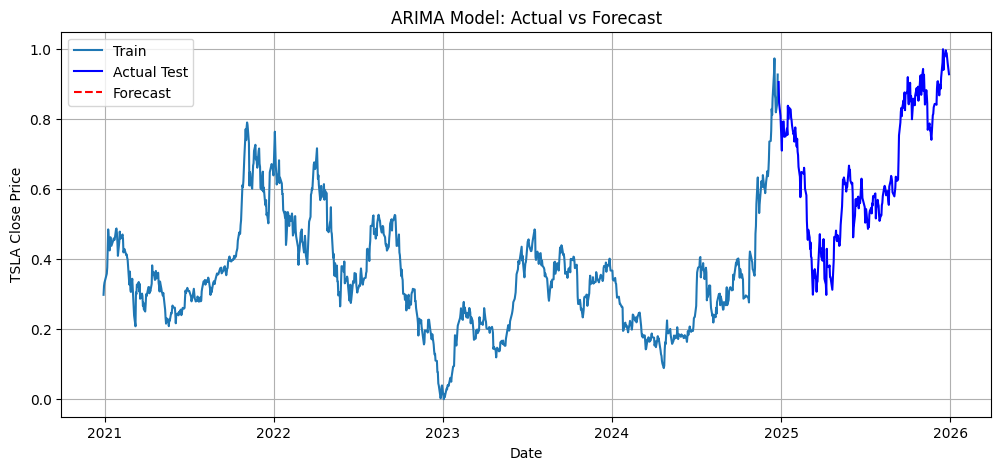

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Actual Test", color="blue")
plt.plot(forecast.index, forecast, label="Forecast", color="red", linestyle="--")

plt.title("ARIMA Model: Actual vs Forecast")
plt.xlabel("Date")
plt.ylabel("TSLA Close Price")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
'''LSTM'''
#we pre define a function to determine the next day price on basis of the price in the last 10 weeks
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)
WINDOW_SIZE = 30

X_train, y_train = create_sequences(train_data.values, WINDOW_SIZE)
X_test, y_test   = create_sequences(test_data.values, WINDOW_SIZE)

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)


X_train shape: (974, 30, 1)
X_test shape : (222, 30, 1)


In [ ]:
#making the model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(WINDOW_SIZE, 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(1))  # Output layer

model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train,
    y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)
#training the model

Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.0391 - val_loss: 0.0111
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0052 - val_loss: 0.0085
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0049 - val_loss: 0.0071
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0037 - val_loss: 0.0068
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0037 - val_loss: 0.0060
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0034 - val_loss: 0.0059
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0034 - val_loss: 0.0045
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0034 - val_loss: 0.0045
Epoch 9/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0030 - val_loss: 0.0065
Epoch 10/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0027 - val_loss: 0.0048
Epoch 11/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0028 - val_loss: 0.0056
Epoch 12/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0

In [ ]:
predictions = model.predict(X_test)


6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


In [ ]:
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
y_test_inv  = scaler.inverse_transform(y_test.reshape(-1, 1))


In [ ]:
mae_lstm = mean_absolute_error(y_test_inv, predictions)
mse_lstm = mean_squared_error(y_test_inv, predictions)
rmse_lstm = np.sqrt(mse_lstm)

print(f"LSTM MAE  : {mae_lstm}")
print(f"LSTM MSE  : {mse_lstm}")
print(f"LSTM RMSE : {rmse_lstm}")


LSTM MAE  : 15.510766519082559
LSTM MSE  : 382.4261509872603
LSTM RMSE : 19.555719137563322


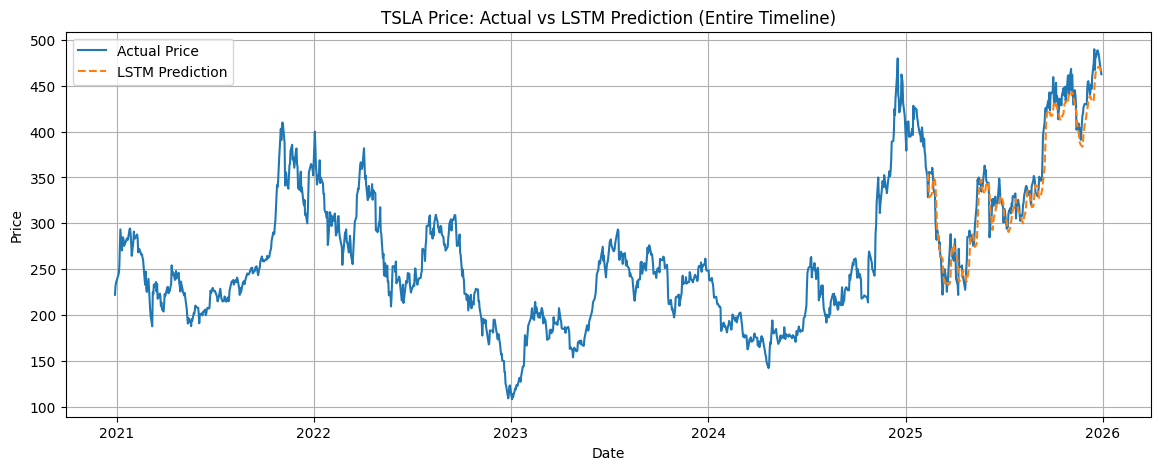

In [ ]:
# Create empty array for full timeline
full_predictions = np.empty(len(ts))
full_predictions[:] = np.nan

# Place predictions at correct indices
full_predictions[train_size + WINDOW_SIZE:] = predictions.flatten()

plt.figure(figsize=(14,5))
plt.plot(ts.index, ts, label="Actual Price")
plt.plot(ts.index, full_predictions, label="LSTM Prediction", linestyle="--")

plt.title("TSLA Price: Actual vs LSTM Prediction (Entire Timeline)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()
